# TF FrozenLake

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make('FrozenLake-v0')

[2017-04-30 22:28:46,624] Making new env: FrozenLake-v0


In [2]:
num_states = env.observation_space.n
num_actions = env.action_space.n
learning_rate = 0.1
gamma = 0.99
epsilon= 0.1
num_episodes = 2000
count_list = []
reward_list = []

In [3]:
graph = tf.Graph()
with graph.as_default():
    state_inputs = tf.placeholder(shape=[1,16],dtype=tf.float32)
    weights = tf.Variable(tf.random_uniform([16,4],0,0.01))
    Qout = tf.matmul(state_inputs,weights)
    predict = tf.argmax(Qout,1)
    nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
    loss = tf.reduce_sum(tf.square(nextQ - Qout))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    opt = optimizer.minimize(loss)

Given a transition $< s, a, r, s^{\prime} >$, the Q-table update rule in
the previous algorithm must be replaced with the
following:

1) Do a feedforward pass for the current state s to get predicted Q-values for all actions.

2) Do a feedforward pass for the next state s’ and calculate maximum overall network outputs $max_{a^{\prime}}Q(s^{\prime}, a^{\prime})$.

3) Set Q-value target for action to $r + \gamma max_{a^{\prime}}Q(s^{\prime}, a^{\prime})$ (use the max calculated in step 2).

4) For all other actions, set the Q-value target to the same as originally returned from step 1, making the error 0 for those outputs.

5) Update the weights using backpropagation.

Assim, em $s$

1) Pegamos $Q(s)$.

2) Com probabilidade $\epsilon$ temos que $a\leftarrow random\_action$. Com probabilidade $1 -\epsilon$ temos que $a\leftarrow arg max_a Q(s, a)$.

3) Executar $a$ e obter $r$ e $s^{\prime}$.

4) $max Q(s^{\prime})$.

5) $TargetQ \leftarrow Q(s)$, $TargetQ[a] \leftarrow r + \gamma max Q(s^{\prime})$. 

6) Minimizar $loss = \sum(TargetQ - Q(s))$.


In [4]:
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    for i in range(num_episodes):
        #Reset environment and get first new observation
        state = env.reset()
        All_reward = 0
        terminate_signal = False
        count = 0
        #The Q-Network
        while count < 99:
            count+=1
            one_hot_state = np.identity(16)[state:state+1] 
            a,Q_state_actions = sess.run([predict,Qout],feed_dict={state_inputs:one_hot_state})
            action = a[0]
            if np.random.rand(1) < epsilon:
                action = env.action_space.sample()
            state_prime,reward,terminate_signal,_ = env.step(action)
            one_hot_state_prime = np.identity(16)[state_prime:state_prime+1]
            Q_state_prime_actions = sess.run(Qout,feed_dict={state_inputs:one_hot_state_prime})
            max_value_in_prime = np.max(Q_state_prime_actions) 
            targetQ = Q_state_actions
            targetQ[0,action] = reward + gamma*max_value_in_prime
            _,W = sess.run([opt,weights],feed_dict={state_inputs:one_hot_state,nextQ:targetQ})
            All_reward += reward
            state = state_prime
            if terminate_signal == True:
                epsilon = 1./((i/50) + 10)
                break
        count_list.append(count)
        reward_list.append(reward)
print("Percent of succesful episodes: " + str(np.mean(reward_list)*100 + "%")

Percent of succesful episodes: 0.405%


### Some statistics on network performance

We can see that the network beings to consistly reach the goal around the 750 episode mark.

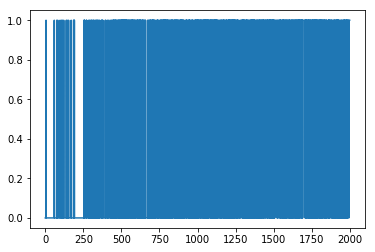

In [7]:
plt.plot(reward_list)

It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.

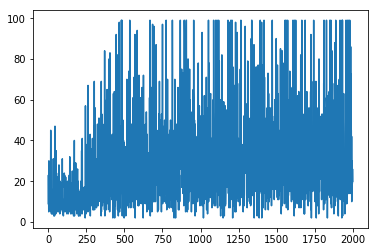

In [6]:
plt.plot(count_list)